In [1]:
import timm
from torchsummary import summary
import torch
from torch import nn
from importlib import reload
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import albumentations
from albumentations import augmentations
from tqdm import tqdm
from tqdm import tqdm_notebook

In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [52]:
base_model = timm.create_model(
            "tf_efficientnet_b4_ns", pretrained=True, num_classes=1
        )
summary(base_model, (3,256,256), device='cpu')

-----------------------------------------------------------------------------------------------
Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2dSame: 1-1                             [-1, 48, 128, 128]        1,296
├─BatchNorm2d: 1-2                            [-1, 48, 128, 128]        96
├─SwishMe: 1-3                                [-1, 48, 128, 128]        --
├─Sequential: 1-4                             [-1, 448, 8, 8]           --
|    └─Sequential: 2-1                        [-1, 24, 128, 128]        --
|    |    └─DepthwiseSeparableConv: 3-1       [-1, 24, 128, 128]        2,940
|    |    └─DepthwiseSeparableConv: 3-2       [-1, 24, 128, 128]        1,206
|    └─Sequential: 2-2                        [-1, 32, 64, 64]          --
|    |    └─InvertedResidual: 3-3             [-1, 32, 64, 64]          11,878
|    |    └─InvertedResidual: 3-4             [-1, 32, 64, 64]          18,120
|    |    └─InvertedResidual: 3-5             [-1, 32, 64

-----------------------------------------------------------------------------------------------
Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2dSame: 1-1                             [-1, 48, 128, 128]        1,296
├─BatchNorm2d: 1-2                            [-1, 48, 128, 128]        96
├─SwishMe: 1-3                                [-1, 48, 128, 128]        --
├─Sequential: 1-4                             [-1, 448, 8, 8]           --
|    └─Sequential: 2-1                        [-1, 24, 128, 128]        --
|    |    └─DepthwiseSeparableConv: 3-1       [-1, 24, 128, 128]        2,940
|    |    └─DepthwiseSeparableConv: 3-2       [-1, 24, 128, 128]        1,206
|    └─Sequential: 2-2                        [-1, 32, 64, 64]          --
|    |    └─InvertedResidual: 3-3             [-1, 32, 64, 64]          11,878
|    |    └─InvertedResidual: 3-4             [-1, 32, 64, 64]          18,120
|    |    └─InvertedResidual: 3-5             [-1, 32, 64

In [41]:
out_128 = torch.randn((21,1792,8,8))

In [49]:
y = torch.nn.functional.adaptive_avg_pool2d(out_128, 1).squeeze()
y.size()

torch.Size([21, 1792])

In [31]:
z = y.T.unsqueeze(0)
z.size()

torch.Size([1, 1792, 16])

In [36]:
p = torch.nn.functional.adaptive_avg_pool1d(z, 1).squeeze(-1)
p.size()

torch.Size([1, 1792])

In [5]:
# reload(classifier_dataset)
from classifier_dataset import Classifier_Dataset
patch_size = 'FULL'
DATA_ROOT = f"Image_Manipulation_Dataset/CASIA_2.0"
df = pd.read_csv(f"casia_tensor_FULL.csv").sample(frac=1).reset_index(drop=True)
valid_aug = albumentations.Compose(
        [
            augmentations.transforms.Resize(
                256, 256, interpolation=cv2.INTER_AREA, always_apply=True, p=1
            )
        ]
    )
dataset = Classifier_Dataset(
    dataframe=df,
    mode="train",
    val_fold=0,
    test_fold=9,
    root_dir=DATA_ROOT,
    patch_size=patch_size,
    equal_sample=False,
    transforms=valid_aug,
)

real:5992, fakes:4082, mode = train


In [6]:
data = dataset[0]
data['image'].size()

torch.Size([21, 1792])

In [10]:
df.head()

,image_patch,mask_patch,label,fold
0,Au/Au_sec_30276.jpg,NaN,0,4
1,Au/Au_arc_30563.jpg,NaN,0,5
2,Au/Au_sec_30296.jpg,NaN,0,4
3,Tp/Tp_D_NNN_S_N_pla00100_ani00079_00540.tif,Gt/Tp_D_NNN_S_N_pla00100_ani00079_00540_gt.png,1,4
4,Au/Au_pla_30127.jpg,NaN,0,5


In [8]:
a = torch.rand((21,1729)).cuda()
a = a.cpu()
torch.save(a, 'a.pt')

In [9]:
torch.load('a.pt')

tensor([[0.0217, 0.6442, 0.0637,  ..., 0.3223, 0.3153, 0.9807],
        [0.6490, 0.7670, 0.7758,  ..., 0.9768, 0.2278, 0.2519],
        [0.8310, 0.4822, 0.2096,  ..., 0.2129, 0.9497, 0.3758],
        ...,
        [0.6718, 0.4022, 0.4911,  ..., 0.4945, 0.0871, 0.8193],
        [0.8695, 0.0543, 0.6936,  ..., 0.6417, 0.9225, 0.6102],
        [0.2248, 0.2314, 0.6229,  ..., 0.0958, 0.2785, 0.2523]])

In [57]:
class Classifier2(nn.Module):
    def __init__(self, in_channels):
        super(Classifier2, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
    def forward(self, x):
        print(x.size())
        y = x.permute((0,2,1))
        print(y.size())
        y = self.gap1D(y).squeeze(-1)
        print(y.size())
        y = self.mlp(y).unsqueeze(1)
        x =  x * y
        print(x.size())
        # x = nn.functional.dropout(x, p=0.3)
        x = x.permute((0,2,1))
        print(x.size())
        x = self.gap1D(x).squeeze(-1)
        print(x.size())
        x = self.fc(x)
        print(x.size())
        return x
cls = Classifier2(32)

In [63]:
cls.eval()
with torch.no_grad():
    out = cls(a.unsqueeze(0))
    print(out.size())
    print(out)

torch.Size([1, 4, 32])
torch.Size([1, 32, 4])
torch.Size([1, 32])
torch.Size([1, 4, 32])
torch.Size([1, 32, 4])
torch.Size([1, 32])
torch.Size([1, 1])
torch.Size([1, 1])
tensor([[-0.0875]])


In [62]:
a = torch.randn((4,32))
a

tensor([[ 0.4595,  1.7999, -1.0719, -1.8899, -0.1033,  0.3146, -0.5297,  0.2071,
          0.4016,  0.2662, -0.7153,  0.2482,  0.6647, -0.9330, -0.6482,  0.3765,
         -0.7108,  0.2405, -1.2318,  0.7380, -0.4547,  0.7189,  0.5235,  0.5527,
         -1.1564, -1.2355,  0.0768,  0.7697, -0.8802, -0.2930, -1.1268,  0.3239],
        [-1.1851,  1.2165, -0.4585, -0.3875,  0.8862, -1.1724,  0.0102,  0.8377,
          1.3142,  0.9334, -0.9755,  1.3035, -2.0160,  0.8756, -0.4537,  0.6825,
         -1.3246,  0.2754, -0.2805, -0.4268,  0.5246,  1.8616,  0.3289, -0.0089,
          0.5929,  0.6829,  0.8500, -1.2328, -0.2356,  0.7952, -0.1406,  2.2772],
        [-0.5855,  0.9057,  1.6336,  0.8976,  0.4098,  0.6671,  1.3417,  1.6650,
          0.6673,  0.8525, -1.6416, -0.8266,  0.9270,  1.3283,  0.3846, -1.7191,
         -0.0598, -0.1000, -0.6661, -1.1861, -0.2559, -0.8025,  0.0561,  2.0211,
          1.3879, -0.4602,  0.4942, -0.2532, -0.6383,  0.4331,  0.7298, -0.4578],
        [-0.6975, -0.5960

In [55]:
class Classifierold(nn.Module):
    def __init__(self, in_channels):
        super(Classifierold, self).__init__()
        
        self.gap1D = nn.AdaptiveAvgPool1d(output_size=1)
        
        ### Fully Connected Multi-Layer Perceptron (FC-MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(in_channels, 1)
        
    def forward(self, x):
        y = x.T.unsqueeze(0)
        y = self.gap1D(y).squeeze(-1)
        y = self.mlp(y)
        x =  x * y
        
        # x = nn.functional.dropout(x, p=0.3)
        x = x.T.unsqueeze(0)
        x = self.gap1D(x).squeeze(-1)
        
        x = self.fc(x)
        
        return x
clso = Classifierold(32)

In [64]:
clso.eval()
with torch.no_grad():
    out = clso(a)
    print(out.size())
    print(out)

torch.Size([1, 1])
tensor([[0.0641]])


In [ ]:
torch.Size([21, 1792])
torch.Size([1, 1792, 21])
torch.Size([1, 1792])
torch.Size([1, 1792, 21])
torch.Size([1, 1792])
torch.Size([1, 1])

In [71]:
from classifier import ClassifierBlock

classifier = ClassifierBlock(8960)
out = classifier(res)
out.size()

torch.Size([1, 4480, 5, 5])
torch.Size([1, 1792, 3, 3])
torch.Size([1, 1792, 3, 3])
torch.Size([1, 1792, 1, 1])


torch.Size([1, 1])

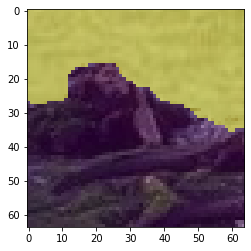

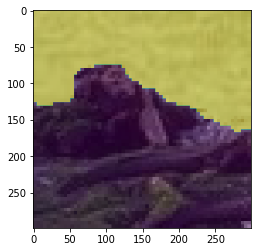

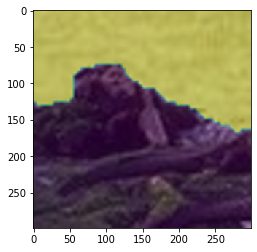

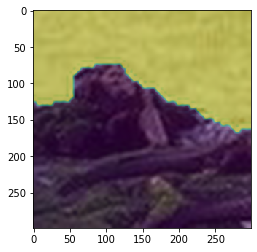

In [65]:
import cv2
import matplotlib.pyplot as plt 

img = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\image_patch_64\\Tp_D_CND_M_N_ani00018_sec00096_00138\\0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
msk = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\image_patch_64\\Tp_D_CND_M_N_ani00018_sec00096_00138\\0_gt.png', cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.imshow(img)
plt.imshow(msk, alpha=0.5)
plt.show()

img1 = cv2.resize(img, (299,299), interpolation=cv2.INTER_AREA)
msk1 = cv2.resize(msk, (299,299), interpolation=cv2.INTER_AREA)
plt.figure()
plt.imshow(img1)
plt.imshow(msk1, alpha=0.5)
plt.show()

img2 = cv2.resize(img, (299,299), interpolation=cv2.INTER_CUBIC)
msk2 = cv2.resize(msk, (299,299), interpolation=cv2.INTER_CUBIC)
plt.figure()
plt.imshow(img2)
plt.imshow(msk2, alpha=0.5)
plt.show()

img3 = cv2.resize(img, (299,299), interpolation=cv2.INTER_LANCZOS4)
msk3 = cv2.resize(msk, (299,299), interpolation=cv2.INTER_LANCZOS4)
plt.figure()
plt.imshow(img3)
plt.imshow(msk3, alpha=0.5)
plt.show()

In [7]:
from EffUnet.EfficientUnet import get_blocks_to_be_concat

blocks = get_blocks_to_be_concat(enc, torch.randn((1,3,256,256)))
for b in blocks.items():
    print(b[0], b[1].size())

blocks_0_output_batch_norm --torch.Size([128, 128])
=====>torch.Size([1, 24, 128, 128])
blocks_1_output_batch_norm --torch.Size([128, 128])
blocks_2_output_batch_norm --torch.Size([64, 64])
=====>torch.Size([1, 32, 64, 64])
blocks_3_output_batch_norm --torch.Size([64, 64])
blocks_4_output_batch_norm --torch.Size([64, 64])
blocks_5_output_batch_norm --torch.Size([64, 64])
blocks_6_output_batch_norm --torch.Size([32, 32])
=====>torch.Size([1, 56, 32, 32])
blocks_7_output_batch_norm --torch.Size([32, 32])
blocks_8_output_batch_norm --torch.Size([32, 32])
blocks_9_output_batch_norm --torch.Size([32, 32])
blocks_10_output_batch_norm --torch.Size([16, 16])
=====>torch.Size([1, 112, 16, 16])
blocks_11_output_batch_norm --torch.Size([16, 16])
blocks_12_output_batch_norm --torch.Size([16, 16])
blocks_13_output_batch_norm --torch.Size([16, 16])
blocks_14_output_batch_norm --torch.Size([16, 16])
blocks_15_output_batch_norm --torch.Size([16, 16])
blocks_16_output_batch_norm --torch.Size([16, 16])


In [19]:
from EffUnet.EfficientUnet import get_efficientunet_b4
model = get_efficientunet_b4()

In [10]:
print(model)

EfficientUnet(
  (encoder): Encoder(
    (stem_conv): Conv2dSamePadding(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (stem_batch_norm): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (stem_swish): Swish()
    (blocks): ModuleList(
      (0): MBConvBlock(
        (swish): Swish()
        (_depthwise_conv): Conv2dSamePadding(48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False)
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dSamePadding(48, 12, kernel_size=(1, 1), stride=(1, 1))
        (_se_expand): Conv2dSamePadding(12, 48, kernel_size=(1, 1), stride=(1, 1))
        (_project_conv): Conv2dSamePadding(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (_bn2): BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      )
      (1): MBConvBlock(
        (swish): Swi

In [5]:
summary(model, (3,256,256), device='cpu')

blocks_0_output_batch_norm --torch.Size([128, 128])
=====>torch.Size([2, 24, 128, 128])
blocks_0_output_batch_norm --torch.Size([128, 128])
=====>torch.Size([2, 24, 128, 128])
blocks_1_output_batch_norm --torch.Size([128, 128])
blocks_1_output_batch_norm --torch.Size([128, 128])
blocks_2_output_batch_norm --torch.Size([64, 64])
=====>torch.Size([2, 32, 64, 64])
blocks_2_output_batch_norm --torch.Size([64, 64])
=====>torch.Size([2, 32, 64, 64])
blocks_3_output_batch_norm --torch.Size([64, 64])
blocks_3_output_batch_norm --torch.Size([64, 64])
blocks_4_output_batch_norm --torch.Size([64, 64])
blocks_4_output_batch_norm --torch.Size([64, 64])
blocks_5_output_batch_norm --torch.Size([64, 64])
blocks_5_output_batch_norm --torch.Size([64, 64])
blocks_6_output_batch_norm --torch.Size([32, 32])
=====>torch.Size([2, 56, 32, 32])
blocks_6_output_batch_norm --torch.Size([32, 32])
=====>torch.Size([2, 56, 32, 32])
blocks_7_output_batch_norm --torch.Size([32, 32])
blocks_7_output_batch_norm --torch

-----------------------------------------------------------------------------------------------
Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [-1, 1792, 8, 8]          --
|    └─Conv2dSamePadding: 2-1                 [-1, 48, 128, 128]        1,296
|    └─BatchNorm2d: 2-2                       [-1, 48, 128, 128]        96
|    └─Swish: 2-3                             [-1, 48, 128, 128]        --
|    └─Conv2dSamePadding: 2-4                 [-1, 1792, 8, 8]          802,816
|    |    └─MBConvBlock: 3-1                  [-1, 24, 128, 128]        2,940
|    |    └─MBConvBlock: 3-2                  [-1, 24, 128, 128]        1,206
|    |    └─MBConvBlock: 3-3                  [-1, 32, 64, 64]          11,878
|    |    └─MBConvBlock: 3-4                  [-1, 32, 64, 64]          18,120
|    |    └─MBConvBlock: 3-5                  [-1, 32, 64, 64]          18,120
|    |    └─MBConvBlock: 3-6                  [-

In [20]:
out = model(torch.randn((1,3,256,256)))
print(out.size())

=====>blocks_0_output_batch_norm ,torch.Size([1, 24, 128, 128])
=====>blocks_2_output_batch_norm ,torch.Size([1, 32, 64, 64])
=====>blocks_6_output_batch_norm ,torch.Size([1, 56, 32, 32])
=====>blocks_10_output_batch_norm ,torch.Size([1, 112, 16, 16])
=====>blocks_22_output_batch_norm ,torch.Size([1, 272, 8, 8])
torch.Size([1, 1792, 8, 8])
torch.Size([1, 512, 16, 16])
---blocks_10_output_batch_norm
torch.Size([1, 624, 16, 16])
torch.Size([1, 512, 16, 16])
torch.Size([1, 256, 32, 32])
---blocks_6_output_batch_norm
torch.Size([1, 312, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([1, 128, 64, 64])
---blocks_2_output_batch_norm
torch.Size([1, 160, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 64, 128, 128])
---blocks_0_output_batch_norm
torch.Size([1, 88, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 32, 256, 256])
---torch.Size([1, 3, 256, 256])
torch.Size([1, 35, 256, 256])
torch.Size([1, 32, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])


In [24]:
eff = timm.create_model('tf_efficientnet_b4_ns')
seq = eff.as_sequential()

In [26]:
print(seq)

Sequential(
  (0): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (2): SwishMe()
  (3): Sequential(
    (0): DepthwiseSeparableConv(
      (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
      (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SwishMe()
      (se): SqueezeExcite(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
        (act1): SwishMe()
        (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act2): Identity()
    )
    (1): DepthwiseSeparableConv(
      (conv_dw): Conv2d(24, 24, kernel_si

In [32]:
from EffUnet.timm_effnet import EfficientNet
summary(EfficientNet('tf_efficientnet_b4_ns'), (3,256,256), device='cpu')

----------------------------------------------------------------------------------------------------
Layer (type:depth-idx)                             Output Shape              Param #
├─Encoder: 1-1                                     [2, 1792, 8, 8]           --
|    └─Sequential: 2-1                             [-1, 48, 128, 128]        --
|    |    └─Conv2dSame: 3-1                        [-1, 48, 128, 128]        1,296
|    |    └─BatchNorm2d: 3-2                       [-1, 48, 128, 128]        96
|    |    └─SwishMe: 3-3                           [-1, 48, 128, 128]        --
|    └─Sequential: 2-2                             [-1, 1792, 8, 8]          --
|    |    └─Conv2d: 3-4                            [-1, 1792, 8, 8]          802,816
|    |    └─BatchNorm2d: 3-5                       [-1, 1792, 8, 8]          3,584
|    |    └─SwishMe: 3-6                           [-1, 1792, 8, 8]          --
├─Sequential: 1-2                                  [-1, 1]                   --
|  

----------------------------------------------------------------------------------------------------
Layer (type:depth-idx)                             Output Shape              Param #
├─Encoder: 1-1                                     [2, 1792, 8, 8]           --
|    └─Sequential: 2-1                             [-1, 48, 128, 128]        --
|    |    └─Conv2dSame: 3-1                        [-1, 48, 128, 128]        1,296
|    |    └─BatchNorm2d: 3-2                       [-1, 48, 128, 128]        96
|    |    └─SwishMe: 3-3                           [-1, 48, 128, 128]        --
|    └─Sequential: 2-2                             [-1, 1792, 8, 8]          --
|    |    └─Conv2d: 3-4                            [-1, 1792, 8, 8]          802,816
|    |    └─BatchNorm2d: 3-5                       [-1, 1792, 8, 8]          3,584
|    |    └─SwishMe: 3-6                           [-1, 1792, 8, 8]          --
├─Sequential: 1-2                                  [-1, 1]                   --
|  

In [14]:
import EffUnet.timm_effunet
reload(EffUnet.timm_effunet)

<module 'EffUnet.timm_effunet' from 'g:\\casia_server\\EffUnet\\timm_effunet.py'>

In [16]:
from EffUnet.timm_effunet import EfficientUnet, get_efficientunet

model = get_efficientunet('tf_efficientnet_b4_ns',out_channels=1)

In [17]:
print(model)

EfficientUnet(
  (encoder): Encoder(
    (stem): Sequential(
      (0): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SwishMe()
    )
    (blocks): Sequential(
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SwishMe()
          (se): SqueezeExcite(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SwishMe()
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1,

here
here


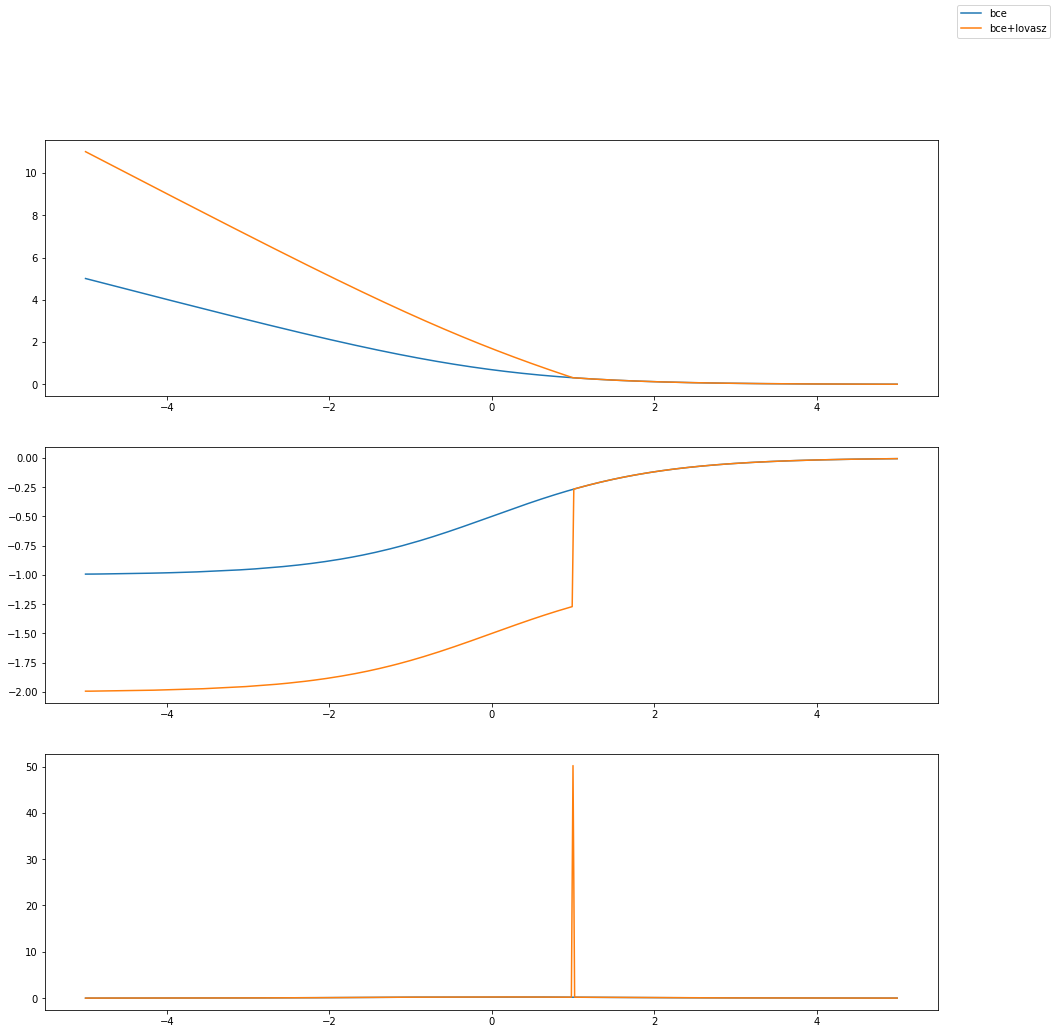

In [2]:
from torch.nn import BCEWithLogitsLoss

from pytorch_toolbelt import losses as L
import numpy as np
import torch
import matplotlib.pyplot as plt


losses = {
    "bce": BCEWithLogitsLoss(),
    # "focal": L.BinaryFocalLoss(),
    # "jaccard": L.BinaryJaccardLoss(),
    # "jaccard_log": L.BinaryJaccardLogLoss(),
    # "dice": L.BinaryDiceLoss(),
    # "dice_log": L.BinaryDiceLogLoss(),
    # "sdice": L.BinarySymmetricDiceLoss(),
    # "sdice_log": L.BinarySymmetricDiceLoss(log_loss=True),
    "bce+lovasz": L.JointLoss(BCEWithLogitsLoss(), L.BinaryLovaszLoss()),
    # "lovasz": L.BinaryLovaszLoss(),
    # "bce+jaccard": L.JointLoss(BCEWithLogitsLoss(),
    #                            L.BinaryJaccardLoss(), 1, 0.5),
    # "bce+log_jaccard": L.JointLoss(BCEWithLogitsLoss(),
    #                            L.BinaryJaccardLogLoss(), 1, 0.5),
    # "bce+log_dice": L.JointLoss(BCEWithLogitsLoss(),
    #                                L.BinaryDiceLogLoss(), 1, 0.5)
    # "reduced_focal": L.BinaryFocalLoss(reduced=True)
}

dx = 0.01
x_vec = torch.arange(-5, 5, dx).view(-1, 1).expand((-1, 100))

f, ax = plt.subplots(3, figsize=(16, 16))

for name, loss in losses.items():
    print('here')
    x_arr = []
    y_arr = []
    target = torch.tensor(1.0).view(1).expand((100))

    for x in x_vec:
        y = loss(x, target).item()

        x_arr.append(float(x[0]))
        y_arr.append(float(y))

    ax[0].plot(x_arr, y_arr, label=name)
    ax[1].plot(x_arr, np.gradient(y_arr, dx))
    ax[2].plot(x_arr, np.gradient(np.gradient(y_arr, dx), dx))

f.legend()
f.show()

In [21]:
import metrics
reload(metrics)

<module 'metrics' from 'g:\\casia_server\\metrics.py'>

In [33]:
from metrics import dice_score

a = torch.randn((4,1,3,3))
b = torch.ones_like(a)
print(a.size(), b.size())
dice = dice_score(a,b)

torch.Size([4, 1, 3, 3])torch.Size([4, 1, 3, 3])
tensor(16.5668)
tensor(52.5668)
tensor(0.6303)
tensor(16.5668)
tensor(52.5668)
tensor(0.6303)


In [51]:
def DiceCoeff(outputs, targets):
    eps = 1e-7
    outputs = torch.sigmoid(outputs)
    intersection = torch.sum(targets * outputs)
    print('inter',intersection)
    union = torch.sum(targets) + torch.sum(outputs)
    print('un',union)
    dice = ((2 * intersection) + eps) / (union + eps)
    print(dice)
    return dice

s = torch.FloatTensor(1).zero_()

for i, c in enumerate(zip(a, b)):
    print(c[0].size())
    s = s + DiceCoeff(c[0], c[1])
print(s)
print(s / (i + 1))

torch.Size([1, 3, 3])
intertensor(3.9308)
untensor(12.9308)
tensor(0.6080)
torch.Size([1, 3, 3])
intertensor(4.7343)
untensor(13.7343)
tensor(0.6894)
torch.Size([1, 3, 3])
intertensor(4.3832)
untensor(13.3832)
tensor(0.6550)
torch.Size([1, 3, 3])
intertensor(3.5186)
untensor(12.5186)
tensor(0.5621)
tensor([2.5145])
tensor([0.6286])


In [49]:
DiceCoeff(a,b)

tensor(16.5668)
tensor(52.5668)
tensor(0.6303)


tensor(0.6303)

In [46]:
def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """
    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:
    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.
    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        print(intersection)
        cardinality = torch.sum(output + target)
        print(cardinality)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

In [53]:
soft_dice_score(torch.sigmoid(a),b)

tensor(16.5668)
tensor(52.5668)


tensor(0.6303)

In [55]:
from seg_metrics import sensitivity, specificity
from sklearn import metrics

sns = sensitivity(torch.sigmoid(a),b)
sps = specificity(torch.sigmoid(a),b)
print(sns)
print(sps)

tensor(0.4722)
tensor(0.)


In [24]:
image = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\Tp\\Tp_D_CNN_M_N_ani00057_ani00055_11149.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

import albumentations
from albumentations import augmentations

image = albumentations.Compose(
        [
            augmentations.transforms.Resize(
                256, 256, interpolation=cv2.INTER_AREA, always_apply=True, p=1
            )
        ]
    )(image=image)['image']

reload(segmentation.timm_efficientnet)
from segmentation.timm_efficientnet import EfficientNet
model = EfficientNet(freeze_encoder=True).get_encoder()

In [22]:
import image_ensemble
reload(image_ensemble)
from image_ensemble import ensemble

out = ensemble(model, image)
out.size()

tensor([[[[-1.7788e-07, -1.5087e-07, -1.6764e-07],
          [-1.7136e-07, -1.4342e-07, -1.5646e-07],
          [-2.0489e-07, -1.8254e-07, -2.0862e-07]],

         [[-1.5646e-07, -1.5274e-07, -1.1921e-07],
          [-1.4529e-07, -1.8626e-07, -1.8626e-07],
          [-1.3411e-07, -1.3411e-07, -1.1176e-07]],

         [[-2.0489e-07, -2.2352e-07, -2.1979e-07],
          [-1.6950e-07, -2.2352e-07, -2.2352e-07],
          [-1.3970e-07, -1.4715e-07, -4.8429e-08]]],


        [[[ 1.2531e-01,  2.4017e-01, -2.4479e-01],
          [ 1.0106e-01,  4.1091e-01, -3.1554e-02],
          [-2.8983e-01, -1.5865e-01, -1.6131e-01]],

         [[ 1.2148e+00,  1.0063e+00,  8.8744e-01],
          [ 1.2015e+00,  9.6837e-01,  9.6837e-01],
          [ 3.4759e-01,  6.5865e-01,  1.8091e-01]],

         [[ 7.2219e-02,  8.7706e-02,  8.7706e-02],
          [-3.3290e-02,  1.9958e-01,  1.9958e-01],
          [-1.3875e-01, -2.3109e-01, -3.0476e-01]]],


        [[[-7.6750e-02, -4.9934e-02, -1.0907e-01],
          [-4.4

torch.Size([21, 1792, 8, 8])

In [25]:
mod2 = EfficientNet(encoder_checkpoint='256_encoder.h5',freeze_encoder=True)
mod2.encoder.state_dict()['stem.0.weight']

tensor([[[[ 9.0496e-42, -1.0803e-41, -5.3614e-42],
          [-8.0350e-42,  6.9967e-42,  2.7325e-42],
          [ 1.5385e-41,  2.9553e-42,  9.2766e-42]],

         [[-7.3792e-42, -6.0774e-42, -1.4013e-43],
          [-1.6108e-41, -1.7628e-42,  1.3849e-41],
          [ 1.2211e-41, -1.2752e-43, -1.4197e-41]],

         [[ 1.5842e-41, -4.3594e-42,  1.7572e-42],
          [ 2.1188e-42,  1.8511e-41,  3.5635e-42],
          [-1.8105e-42, -1.6416e-41, -1.1730e-41]]],


        [[[-2.8722e-10,  2.3985e-10,  2.0174e-09],
          [-5.8118e-10,  6.7257e-10,  1.4582e-08],
          [-1.0621e-07, -2.5503e-07, -7.9956e-07]],

         [[-9.9633e-12,  1.1488e-12,  4.2494e-10],
          [-1.5539e-12,  9.0848e-12,  1.9512e-08],
          [ 6.3751e-08,  9.2355e-07,  1.2056e-06]],

         [[ 2.4422e-08,  4.5769e-08,  1.7544e-07],
          [ 2.2404e-08,  9.6743e-08,  3.9972e-07],
          [ 5.0353e-10, -4.1284e-07, -2.5812e-06]]],


        [[[-1.5621e-05, -9.6814e-07, -1.0673e-05],
          [ 8.2

In [2]:
from segmentation.timm_efficientnet import EfficientNet
from image_ensemble import ensemble

patch_size = 'FULL'
DATA_ROOT = f"Image_Manipulation_Dataset/CASIA_2.0"
df = pd.read_csv(f"casia_{patch_size}.csv").sample(frac=1).reset_index(drop=True)
model = EfficientNet().get_encoder().cuda()

In [3]:
df['tensor'] = -1

In [4]:
with tqdm_notebook(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        fname = row['image_patch'].split('/')[-1][:-4]
        if os.path.exists(fname+".pt"):
            df.loc[i, 'tensor'] = fname+".pt"
        else:
            image = cv2.imread(os.path.join(DATA_ROOT, row['image_patch']))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA)
            # plt.imshow(image)
            # plt.show()
            tensor = ensemble(model, image)
            tensor = tensor.cpu()
            torch.save(tensor, f'Image_Manipulation_Dataset/CASIA_2.0/full_tensors/{fname + ".pt"}')
            df.loc[i, 'tensor'] = fname+".pt"
        pbar.update(1)

In [2]:
from casia_dataset import CASIA

patch_size = 'FULL'
DATA_ROOT = f"G:\\Image_Manipulation_Dataset\\CASIA_2.0"
df = pd.read_csv(f"casia_{patch_size}.csv").sample(frac=1).reset_index(drop=True)

valid_aug = albumentations.Compose([
    augmentations.transforms.Resize(
        224, 224, interpolation=cv2.INTER_AREA, always_apply=True, p=1
    ),
    albumentations.Normalize(
        mean=[0.42468103282400615, 0.4259826707370029, 0.38855473517307415], 
        std=[0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
        always_apply=True, p=1
    ),
    albumentations.pytorch.ToTensor()
])
valid_dataset = CASIA(
    dataframe=df,
    mode="val",
    val_fold=0,
    test_fold=9,
    root_dir=DATA_ROOT,
    patch_size=patch_size,
    equal_sample=False,
    transforms=valid_aug,
)

real:750, fakes:510, mode = val


torch.Size([3, 224, 224])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


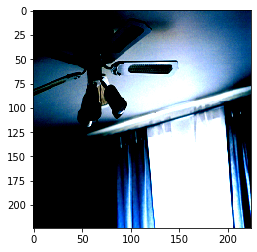

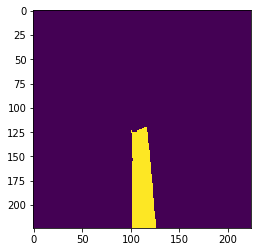

In [4]:
data = valid_dataset[5]
print(data['image'].size())
plt.figure()
plt.imshow(data['image'].permute((1,2,0)))
plt.show()
plt.figure()
plt.imshow(data['mask'].permute((1,2,0)).squeeze())
plt.show()

In [49]:
from albumentations.pytorch.functional import img_to_tensor
torch.set_printoptions(threshold=5000)
normalize = {
    "mean": [0.42468103282400615, 0.4259826707370029, 0.38855473517307415],
    "std": [0.2744059987371694, 0.2684138285232067, 0.29527622263685294],
}
valid_aug = albumentations.Compose(
    [
        augmentations.transforms.Resize(
            64, 64, interpolation=cv2.INTER_AREA, always_apply=True, p=1
        ),
        albumentations.Normalize(mean=normalize['mean'], std=normalize['std'], p=1),
        albumentations.pytorch.ToTensor()
    ]
)
image = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\Tp\\Tp_D_CNN_M_N_cha00026_cha00028_11784.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread('G:\\Image_Manipulation_Dataset\\CASIA_2.0\\Gt\\Tp_D_CNN_M_N_cha00026_cha00028_11784_gt.png', cv2.IMREAD_GRAYSCALE)

data = valid_aug(image=image, mask=mask_image)
image = data['image']
mask_image = data['mask']

# image = img_to_tensor(image, normalize)
# mask_image = img_to_tensor(mask_image).unsqueeze(0)

# image.size()
mask_image.size()

# plt.imshow(mask_image.permute((1,2,0)))
# plt.show()
print(mask_image)

torch.Size([1, 64, 64])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [2]:
import segmentation_models_pytorch as smp
model = smp.Unet('timm-efficientnet-b4', classes=1, encoder_weights='imagenet', activation='sigmoid')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_aa-818f208c.pth" to C:\Users\sowme/.cache\torch\checkpoints\tf_efficientnet_b4_aa-818f208c.pth


In [3]:
print(model)

Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Swish()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): Swish()
          (se): SqueezeExcite(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, 

In [5]:
summary(model, (3,224,224))

----------------------------------------------------------------------------------------------------
Layer (type:depth-idx)                             Output Shape              Param #
├─EfficientNetEncoder: 1-1                         [2, 3, 224, 224]          --
|    └─Conv2d: 2-1                                 [-1, 48, 112, 112]        1,296
|    └─BatchNorm2d: 2-2                            [-1, 48, 112, 112]        96
|    └─Swish: 2-3                                  [-1, 48, 112, 112]        --
├─UnetDecoder: 1-2                                 [-1, 16, 224, 224]        --
|    └─Identity: 2-4                               [-1, 448, 7, 7]           --
├─SegmentationHead: 1-3                            [-1, 1, 224, 224]         --
|    └─Conv2d: 2-5                                 [-1, 1, 224, 224]         145
|    └─Identity: 2-6                               [-1, 1, 224, 224]         --
|    └─Activation: 2-7                             [-1, 1, 224, 224]         --
|    |    

----------------------------------------------------------------------------------------------------
Layer (type:depth-idx)                             Output Shape              Param #
├─EfficientNetEncoder: 1-1                         [2, 3, 224, 224]          --
|    └─Conv2d: 2-1                                 [-1, 48, 112, 112]        1,296
|    └─BatchNorm2d: 2-2                            [-1, 48, 112, 112]        96
|    └─Swish: 2-3                                  [-1, 48, 112, 112]        --
├─UnetDecoder: 1-2                                 [-1, 16, 224, 224]        --
|    └─Identity: 2-4                               [-1, 448, 7, 7]           --
├─SegmentationHead: 1-3                            [-1, 1, 224, 224]         --
|    └─Conv2d: 2-5                                 [-1, 1, 224, 224]         145
|    └─Identity: 2-6                               [-1, 1, 224, 224]         --
|    └─Activation: 2-7                             [-1, 1, 224, 224]         --
|    |    

In [2]:
x = []
y = []
a = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,1,1,1,1,1,1,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0]
])
b = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0.5,0.75,0,0,0,0],
    [0,0,0,0.9,0.85,0.77,0.65,0,0,0],
    [0,0,0.88,1,0.65,1,0.71,0.98,0,0],
    [0,0,0,1,0.33,1,0.84,0,0,0],
    [0,0,0,0,0.25,0.77,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0]
])

In [5]:
z = torch.ones((1,224,224))

In [6]:
torch.sum(z).item()

50176.0

In [69]:
a = torch.randn((4,1,224,224))
z = []
for _ in range(10):
    z.extend(list(a))
print(len(z))
print(z[0].size())
print(torch.stack(z).size())

40
torch.Size([1, 224, 224])
torch.Size([40, 1, 224, 224])


In [63]:
for _ in range(10):
    x.append(a)
    y.append(b)

In [57]:
x[0].size()

torch.Size([7, 10])

In [35]:
def dice_score(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):

    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets + outputs)
    dice = ((2 * intersection) + eps) / (union + eps)
    
    return dice #single float

In [3]:
from pytorch_toolbelt.losses.functional import soft_dice_score

def dice_coeff(outputs : list, targets : list): 
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(outputs, targets)):
        s = s + soft_dice_score(c[0], c[1])
    return s / (i + 1)

In [5]:
soft_dice_score(b,a).item()

0.868991494178772

(5, 6, 224, 224)


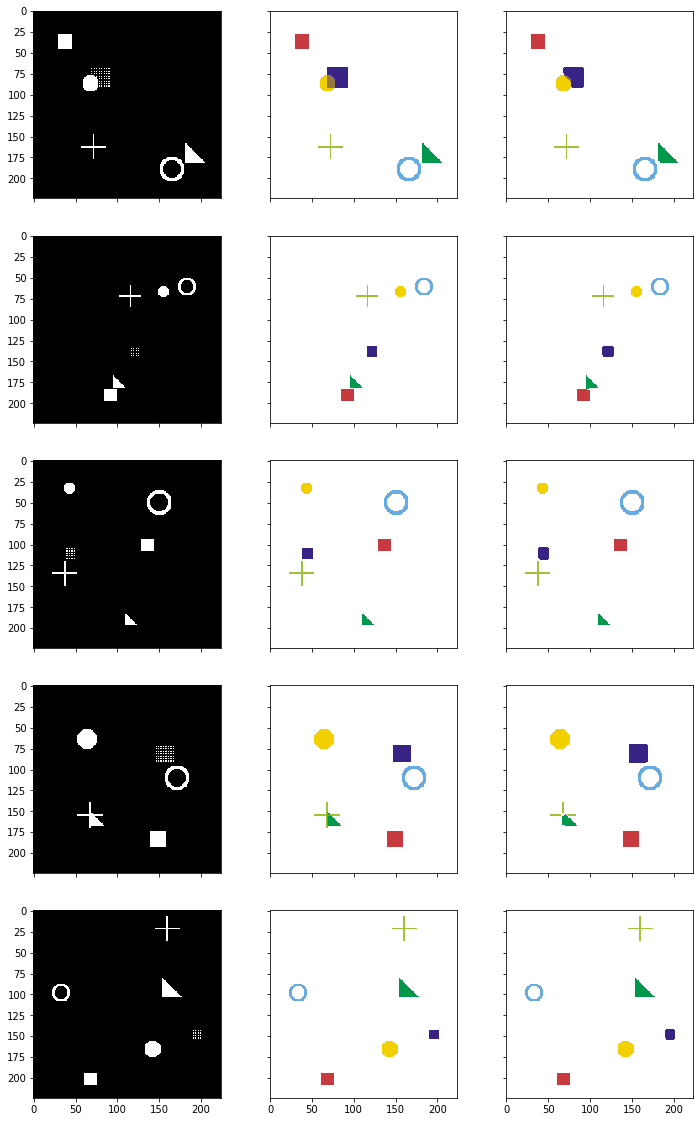

In [18]:
import segmentation_models_pytorch as smp
from sim_dataset import SimDataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import helper
from torchvision import transforms

device = 'cuda'
model = smp.Unet('timm-efficientnet-b4', classes=6, encoder_weights='imagenet')
model.load_state_dict(torch.load('weights/Simulation_64Unet(end-end)_[02|10_11|49|35].h5'))
model.to(device)
model.eval()   # Set model to the evaluation mode

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])
# Create another simulation dataset for test
test_dataset = SimDataset(5, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)

# Get the first batch
data = next(iter(test_loader))
inputs = data['image']
labels = data['mask']
inputs = inputs.to(device)
labels = labels.to(device)


# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().detach().numpy()
print(pred.shape)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])